In [2]:
!pip install -U -q PyDrive

     |████████████████████████████████| 993kB 10.0MB/s 


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
t = drive.CreateFile({'id':'0B0Fef71_vt3PUkZ4YVZ5WWNvZWs'})
t.GetContentFile('dataset.tar.gz')

In [9]:
!tar -xvzf dataset.tar.gz

sat-4-full.mat
sat-6-full.mat
./._readme.txt
readme.txt


In [0]:
import scipy.io as sio

IMAGES_DATA_PATH = 'sat-6-full.mat'

def load_image_data(images_data_path=IMAGES_DATA_PATH):
    print("##########    Loading Data    ##########")    
    test = sio.loadmat(images_data_path)
    print(test)
    print("##########    Data type    ###########")
    print(type(test))
    print(test.values())
    return test

 

Using TensorFlow backend.


Training data shape :  (28, 28, 4, 324000) (6, 324000)
Testing data shape :  (28, 28, 4, 81000) (6, 81000)
Training data shape :  (324000, 28, 28, 4) (324000, 6)
Testing data shape :  (81000, 28, 28, 4) (81000, 6)
Original label 0 :  [0 0 1 0 0 0]
After conversion to categorical ( one-hot ) :  [0 0 1 0 0 0]
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 324000 samples, validate on 81000 samples
Epoch 1/10
324000/324000 [==============================] - 66s 203us/step - loss: 0.3195 - acc: 0.8836 - val_loss: 0.1157 - val_acc: 0.9570
Epoch 2/10
324000/324000 [==============================] - 50s 154us/step - loss: 0.1075 - acc: 0.9587 - val_loss: 0.1733 - val_acc: 0.9355
Epoch 3/10
324000/324000 [==============================] - 50s 153us/step - loss: 0.0760 - acc: 0.9728 - val_loss: 0.0613 

Text(0.5, 1.0, 'Accuracy Curves')

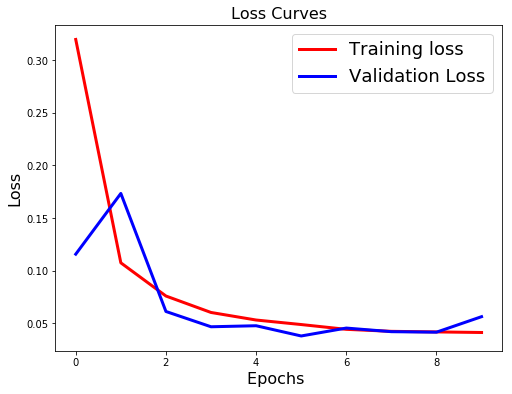

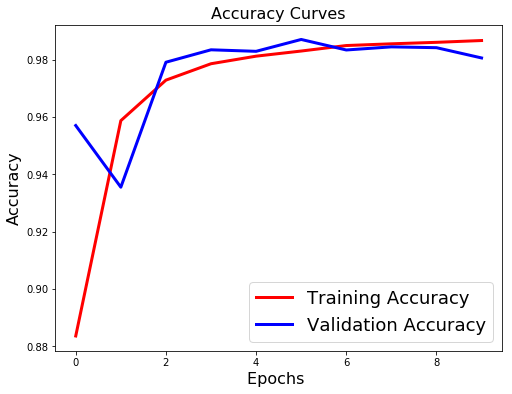

In [11]:
#checkout the data
from keras.utils import to_categorical
from keras import optimizers

#models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

#helper
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


 

###############################################################################
#load the data
import scipy.io
data = scipy.io.loadmat("sat-6-full.mat")
train_images = data['train_x']
train_labels = data['train_y']

test_images = data['test_x']
test_labels = data['test_y']

####################################################################
#Checkout the data
print('Training data shape : ', train_images.shape, train_labels.shape)
print('Testing data shape : ', test_images.shape, test_labels.shape)

#Change the dimension to fit into the model
x_train = train_images.transpose(3,0,1,2)
t_train = train_labels.transpose()

x_test = test_images.transpose(3,0,1,2)
t_test = test_labels.transpose()

print('Training data shape : ', x_train.shape, t_train.shape)
print('Testing data shape : ', x_test.shape, t_test.shape)


#Find the unique numbers from the train labels
nClasses = 6
 
#Display the change for category label using one-hot encoding
print('Original label 0 : ', t_train[0])
print('After conversion to categorical ( one-hot ) : ', t_train[0])


##################################################################
#preprocess
#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255
#memory error may be because entire data set could not fit into RAM

#preprocess
for t in x_train:
    t = t.astype('float32')
    t /= 255
for t in x_test:
    t = t.astype('float32')
    t /= 255
    
###########################################################################################3
def createModel():
    model = Sequential()
    model.add(Conv2D(28, (3, 3), padding='same', activation='relu', input_shape=(28 , 28 , 4)))
    model.add(Conv2D(28, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(56, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(56, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Conv2D(56, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(56, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))
     
    return model
#################################################################################
#serialize model to JSON
def SerializeToJSON(model,model_path):
    model_json = model.to_json()
    model_json_file_name = input("Enter json filename to save :")
    model_json_file_path = model_path + model_json_file_name
    print(model_json_file_path)
    with open(model_json_file_path, "w") as json_file:
        json_file.write(model_json)

    #serialize weights to HDF5
    model_weight_json_file_name = input("Enter json weight filename to save :")
    model_json_weight_file_path = model_path + model_weight_json_file_name
    model.save_weights(model_json_weight_file_path)
    print("Saved model json to the disk")

#Training the network
model1 = createModel()

batch_size = 256
epochs = 10
rms = optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
model1.compile(optimizer=rms, loss='categorical_crossentropy', metrics=['accuracy'])
 
history = model1.fit(x_train, t_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, t_test))
 
score, accuracy = model1.evaluate(x_test, t_test)

#######################################################
#Serialize model
# model_path = "../../models/"
# SerializeToJSON(model1,model_path)

#model_path = "../models/land_classifiction_Lr0.0001_v1.yaml"
#SerializeToYAML(model,model_path)

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [12]:
score, accuracy = model1.evaluate(x_test, t_test)
print("Score: ", score)
print("Accuracy: ", accuracy)

81000/81000 [==============================] - 7s 84us/step
Score:  0.056343959150755386
Accuracy:  0.9805432098765432
